In [1]:
from setup import *

# Simulation of sequencing artefacts from DNA templates

## simulation function

In [2]:
def simulate_artefacts_with_diff_concordant_ratios (candidate_sites, initial_hits_perc, seq_chance, rand_seed):
    np.random.seed(rand_seed) 
    
    ## simulate total deamination events, and the initial chance of being deaminated is the same for both types of cytosines:
    total_hits_num = int(candidate_sites * initial_hits_perc)    ## total deaminated sites among all candidates
    
    hit_sets_s1 = random.sample(range(candidate_sites), total_hits_num)    ## randomly assign the total deaminated events for all candidates in sample 1
    hit_sets_s2 = random.sample(range(candidate_sites), total_hits_num)    ## randomly assign the total deaminated events for all candidates in sample 2

    ## simulate the sequencing process, assuming uracial-containing templates are more likely degraded and also not being favoured during PCR 
    seq_hits_num = int(total_hits_num * seq_chance)    ## total deaminated events would be sequenced
    
    hits_s1_seq = hit_sets_s1[:seq_hits_num]    ## we took the actual-sequenced hits out from sample 1
    hits_s2_seq = hit_sets_s2[:seq_hits_num]    ## we took the actual-sequenced hits out from sample 2

    concordant_hits_s1_s2 = len(np.intersect1d(hits_s1_seq, hits_s2_seq))    ## checking the concordant hits between the sequenced ones. the numerator 

    total_hits_s1_s2 = len(set(list(hits_s1_seq)+list(hits_s2_seq)))    ## checking the total intersection of artefacts observed in s1 and s2. the denonamitor
    
    return (concordant_hits_s1_s2, total_hits_s1_s2, concordant_hits_s1_s2/total_hits_s1_s2)    ## return the abosolute num and concordant ratio back

## Channel index

In [3]:
## channel index 
C2T_CpG_ind = []
C2T_nonCpG_ind = []

for c in channels:
    c1,c2 = c.split("@")
    C2T_CpG_ind.append(c1 == "C>T" and c2[1:] == "CG")
    C2T_nonCpG_ind.append(c1 == "C>T" and c2[1:] != "CG")

## unrepaired sig (CpG and nonCpG distribution)

CpG_props_unrepaired = ffpe_sig_unrepaired[C2T_CpG_ind]
norm_CpG_props_unrepaired = CpG_props_unrepaired/sum(CpG_props_unrepaired)

nonCpG_props_unrepaired = ffpe_sig_unrepaired[C2T_nonCpG_ind]
norm_nonCpG_props_unrepaired = nonCpG_props_unrepaired/sum(nonCpG_props_unrepaired)

## repaired sig (CpG and nonCpG distribution)
CpG_props_repaired = ffpe_sig_repaired[C2T_CpG_ind]
norm_CpG_props_repaired = CpG_props_repaired/sum(CpG_props_repaired)

nonCpG_props_repaired = ffpe_sig_repaired[C2T_nonCpG_ind]
norm_nonCpG_props_repaired = nonCpG_props_repaired/sum(nonCpG_props_repaired)

## Normalisation
def transfer_sig(from_sig, from_opp, to_opp = wgs_opp):
    to_sig = from_sig / from_opp * to_opp
    to_sig = to_sig / np.sum(to_sig)
    return (to_sig)

## General facts for simulation setup

In [4]:
cytosine_sites = 31344     ## Total cytosine sites based the targeted gene opportunity matrix (Fig S5a)

CpG_opp = opportunity_TargetCRC[C2T_CpG_ind].sum()/(opportunity_TargetCRC[C2T_nonCpG_ind].sum() + opportunity_TargetCRC[C2T_CpG_ind].sum())

CpG_sites_num = cytosine_sites * CpG_opp * 0.75  ## 5mC numbers (0.75 is the mean of methylation rate (70-80%))

non_CpG_sites_num = cytosine_sites - CpG_sites_num ## non-5mC numbers

initial_deaminated_perc = 0.45 ## same for CpG_sites and nonCpG sites.

print (f"Total cytosine number = {int(cytosine_sites)}, CpG sites = {int(CpG_sites_num)}, nonCpG sites = {int(non_CpG_sites_num)}")

Total cytosine number = 31344, CpG sites = 3025, nonCpG sites = 28318


# Simulate unrepaired samples

## With sampling bias

In [5]:
simulated_unrepaired_biased = pd.DataFrame()

cs_to_repaired_sig_biased = []
cs_to_unrepaired_sig_biased = []

concordant_ratios_nonCpG_biased = []
concordant_ratios_CpG_biased = []

for i in range(100):
    sample_id = 's' + str(i)
    np.random.seed (i)
    concordant_mut_num_nonCpG, total_mut_num_nonCpG, concordant_ratio_nonCpG= simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(non_CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.3,0.4), ## non-CpG templates are not favoured
                                                                                rand_seed = i)

    concordant_mut_num_CpG, total_mut_num_CpG, concordant_ratio_CpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.85,0.95), ## CpG templates are favoured
                                                                                rand_seed = i)

    mut_profile_of_given_sample =  np.zeros (96)
    mut_profile_of_given_sample [C2T_CpG_ind]= norm_CpG_props_unrepaired * int(total_mut_num_CpG/2)
    mut_profile_of_given_sample [C2T_nonCpG_ind]= norm_nonCpG_props_unrepaired * int(total_mut_num_nonCpG/2)
    simulated_unrepaired_biased[sample_id] = np.random.poisson(mut_profile_of_given_sample)
    
    concordant_mut_profile = np.zeros (96)
    concordant_mut_profile[C2T_CpG_ind] = norm_CpG_props_unrepaired * int(concordant_mut_num_CpG/2)
    concordant_mut_profile[C2T_nonCpG_ind] = norm_nonCpG_props_unrepaired * int(concordant_mut_num_nonCpG/2)
    
    cs_to_repaired_sig_biased.append(cosine_similarity(ffpe_sig_repaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    cs_to_unrepaired_sig_biased.append(cosine_similarity(ffpe_sig_unrepaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    
    concordant_ratios_nonCpG_biased.append(concordant_ratio_nonCpG)
    concordant_ratios_CpG_biased.append(concordant_ratio_CpG)

## transfer the mutational probabilities to WGS sequence context:
simulated_unrepaired_biased_transferred = simulated_unrepaired_biased.T.apply(lambda row: transfer_sig(
                                            from_sig = row,
                                            from_opp = np.array (opportunity_TargetCRC), 
                                            to_opp = wgs_opp), axis = 1)
unrepaired_bias_sig = simulated_unrepaired_biased_transferred.mean().values

## Without sampling bias

In [6]:
initial_deaminated_perc = 0.45 ## same for CpG_sites and nonCpG sites.

simulated_unrepaired_unbiased = pd.DataFrame()

cs_to_repaired_sig_unbiased = []
cs_to_unrepaired_sig_unbiased = []

concordant_ratios_nonCpG_unbiased = []
concordant_ratios_CpG_unbiased = []

for i in range(100):
    sample_id = 's' + str(i)
    np.random.seed (i)
    concordant_mut_num_nonCpG, total_mut_num_nonCpG, concordant_ratio_nonCpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(non_CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.45,0.55), ## non-CpG templates are equally favoured
                                                                                rand_seed = i)

    concordant_mut_num_CpG, total_mut_num_CpG, concordant_ratio_CpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.45,0.55), ## non-CpG templates are equally favoured                 
                                                                                rand_seed = i)

    mut_profile_of_given_sample =  np.zeros (96)
    mut_profile_of_given_sample [C2T_CpG_ind]= norm_CpG_props_unrepaired * int(total_mut_num_CpG/2)
    mut_profile_of_given_sample [C2T_nonCpG_ind]= norm_nonCpG_props_unrepaired * int(total_mut_num_nonCpG/2)
    simulated_unrepaired_unbiased[sample_id] = np.random.poisson(mut_profile_of_given_sample)
    
    concordant_mut_profile = np.zeros (96)
    concordant_mut_profile[C2T_CpG_ind] = norm_CpG_props_unrepaired * int(concordant_mut_num_CpG/2)
    concordant_mut_profile[C2T_nonCpG_ind] = norm_nonCpG_props_unrepaired * int(concordant_mut_num_nonCpG/2)
    
    cs_to_repaired_sig_unbiased.append(cosine_similarity(ffpe_sig_repaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    cs_to_unrepaired_sig_unbiased.append(cosine_similarity(ffpe_sig_unrepaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    
    concordant_ratios_nonCpG_unbiased.append(concordant_ratio_nonCpG)
    concordant_ratios_CpG_unbiased.append(concordant_ratio_CpG)
    
simulated_unrepaired_unbiased_transferred = simulated_unrepaired_unbiased.T.apply(lambda row: transfer_sig(
                                            from_sig = row,
                                            from_opp = np.array (opportunity_TargetCRC), 
                                            to_opp = wgs_opp), axis = 1)
unrepaired_unbias_sig = simulated_unrepaired_unbiased_transferred.mean().values

## Visualise the key information

In [7]:
## Record the key information from the simulated data (unrepaired-biased)
ratio, sim, bias_info, site_info, sig_info = [], [], [], [], []

ratio = concordant_ratios_CpG_biased + concordant_ratios_nonCpG_biased + concordant_ratios_CpG_unbiased + concordant_ratios_nonCpG_unbiased
sim = cs_to_repaired_sig_biased + cs_to_unrepaired_sig_biased + cs_to_repaired_sig_unbiased + cs_to_unrepaired_sig_unbiased 
bias_info = ['With-bias'] * 200 + ['Without-bias'] * 200
site_info = ['CpG'] * 100 + ["nonCpG"] * 100 + ['CpG'] * 100 + ["nonCpG"] * 100
sig_info = ['Repaired-sig'] * 100 + ['Unrepaired-sig'] * 100 + ['Repaired-sig'] * 100 + ['Unrepaired-sig'] * 100

ratio_sim_unrepaired_df = pd.DataFrame()
ratio_sim_unrepaired_df['sim'] = sim
ratio_sim_unrepaired_df['ratio'] = ratio
ratio_sim_unrepaired_df['site_info'] = site_info
ratio_sim_unrepaired_df['bias_info'] = bias_info
ratio_sim_unrepaired_df['sig_info'] = sig_info

ratio_sim_unrepaired_df.head()

,sim,ratio,site_info,bias_info,sig_info
0,0.894582,0.247846,CpG,With-bias,Repaired-sig
1,0.917965,0.260260,CpG,With-bias,Repaired-sig
2,0.903989,0.264033,CpG,With-bias,Repaired-sig
3,0.906603,0.256764,CpG,With-bias,Repaired-sig
4,0.874224,0.272099,CpG,With-bias,Repaired-sig


In [8]:
ratio_sim_unrepaired_df.groupby(['bias_info', 'sig_info']).mean()

sim     ratio
bias_info    sig_info                          
With-bias    Repaired-sig    0.906527  0.252408
             Unrepaired-sig  0.708857  0.085202
Without-bias Repaired-sig    0.441866  0.126130
             Unrepaired-sig  0.996260  0.125633

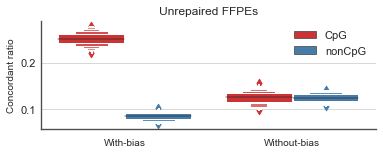

In [9]:
sns.set(rc={"figure.figsize":(6, 2)})
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                     'ytick.major.size': 2,
                                                     'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})
sns.boxenplot(x = 'bias_info', y = 'ratio', data = ratio_sim_unrepaired_df, hue = "site_info", palette= "Set1")
plt.legend (title = "", ncol = 1, frameon = False)
sns.despine()
plt.ylabel ("Concordant ratio", fontsize = 10)
plt.xlabel ("")
plt.title("Unrepaired FFPEs")

plt.xticks(fontsize = 10)
plt.savefig("./Figures/Fig_R3a.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

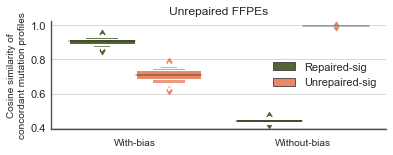

In [10]:
sns.set(rc={"figure.figsize":(6, 2)})
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                     'ytick.major.size': 2,
                                                     'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})
sns.boxenplot(x = 'bias_info', y = 'sim', data = ratio_sim_unrepaired_df, hue = "sig_info", palette= {"Repaired-sig":'darkolivegreen', "Unrepaired-sig": 'coral'})
plt.legend (title = "", loc = "center right", ncol = 1, frameon = False)
sns.despine()
plt.ylabel ("Cosine similarity of\nconcordant mutation profiles", fontsize = 10)
plt.xlabel ("")
plt.xticks(fontsize = 10)
plt.title("Unrepaired FFPEs")

plt.savefig("./Figures/FigR_3b.pdf", bbox_inches = "tight", dpi = 300)

plt.show()

## Repaired FFPE

Here we assume there are about ~0.75% of deaminated nonCpG sites that are escaped from chemical treatment for both with-biase and without bias samples.  

## With bias

In [11]:
simulated_repaired_biased = pd.DataFrame()

cs_to_repaired_sig_biased = []
cs_to_unrepaired_sig_biased = []

concordant_ratios_nonCpG_biased = []
concordant_ratios_CpG_biased = []

for i in range(100):
    sample_id = 's' + str(i)
    np.random.seed (i)
    concordant_mut_num_nonCpG, total_mut_num_nonCpG, concordant_ratio_nonCpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(non_CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.005,0.01), ## escaped from chemical treatment
                                                                                rand_seed = i)

    concordant_mut_num_CpG, total_mut_num_CpG, concordant_ratio_CpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                               seq_chance = np.random.uniform(0.85,0.95), ## CpG templates are favoured
                                                                                #seq_chance = np.random.uniform(0.45,0.55), ## non-CpG templates are favoured                 
                                                                                rand_seed = i)

    mut_profile_of_given_sample =  np.zeros (96)
    mut_profile_of_given_sample [C2T_CpG_ind]= norm_CpG_props_repaired * int(total_mut_num_CpG/2)
    mut_profile_of_given_sample [C2T_nonCpG_ind]= norm_nonCpG_props_repaired * int(total_mut_num_nonCpG/2)
    simulated_repaired_biased[sample_id] = np.random.poisson(mut_profile_of_given_sample)

    concordant_mut_profile = np.zeros (96)
    concordant_mut_profile[C2T_CpG_ind] = norm_CpG_props_repaired * int(concordant_mut_num_CpG/2)
    concordant_mut_profile[C2T_nonCpG_ind] = norm_nonCpG_props_repaired * int(concordant_mut_num_nonCpG/2)
    
    cs_to_repaired_sig_biased.append(cosine_similarity(ffpe_sig_repaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    cs_to_unrepaired_sig_biased.append(cosine_similarity(ffpe_sig_unrepaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    
    concordant_ratios_nonCpG_biased.append(concordant_ratio_nonCpG)
    concordant_ratios_CpG_biased.append(concordant_ratio_CpG)

simulated_repaired_biased_transferred = simulated_repaired_biased.T.apply(lambda row: transfer_sig(
                                            from_sig = row,
                                            from_opp = np.array (opportunity_TargetCRC), 
                                            to_opp = wgs_opp), axis = 1)
repaired_bias_sig = simulated_repaired_biased_transferred.mean().values

## without bias 

In [12]:
simulated_repaired_unbiased = pd.DataFrame()

cs_to_repaired_sig_unbiased = []
cs_to_unrepaired_sig_unbiased = []

concordant_ratios_nonCpG_unbiased = []
concordant_ratios_CpG_unbiased = []

for i in range(100):
    sample_id = 's' + str(i)
    np.random.seed (i)
    concordant_mut_num_nonCpG, total_mut_num_nonCpG, concordant_ratio_nonCpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(non_CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.005,0.01), ## escaped from chemical treatment
                                                                                rand_seed = i)

    concordant_mut_num_CpG, total_mut_num_CpG, concordant_ratio_CpG = simulate_artefacts_with_diff_concordant_ratios(candidate_sites = int(CpG_sites_num), 
                                                                                initial_hits_perc = initial_deaminated_perc, 
                                                                                seq_chance = np.random.uniform(0.45,0.55), ## non-CpG templates are favoured                 
                                                                                rand_seed = i)

    mut_profile_of_given_sample =  np.zeros (96)
    mut_profile_of_given_sample [C2T_CpG_ind]= norm_CpG_props_repaired * int(total_mut_num_CpG/2)
    mut_profile_of_given_sample [C2T_nonCpG_ind]= norm_nonCpG_props_repaired * int(total_mut_num_nonCpG/2)
    simulated_repaired_unbiased[sample_id] = np.random.poisson(mut_profile_of_given_sample)

    concordant_mut_profile = np.zeros (96)
    concordant_mut_profile[C2T_CpG_ind] = norm_CpG_props_repaired * int(concordant_mut_num_CpG/2)
    concordant_mut_profile[C2T_nonCpG_ind] = norm_nonCpG_props_repaired * int(concordant_mut_num_nonCpG/2)
    
    cs_to_repaired_sig_unbiased.append(cosine_similarity(ffpe_sig_repaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    cs_to_unrepaired_sig_unbiased.append(cosine_similarity(ffpe_sig_unrepaired.reshape(1,96), concordant_mut_profile.reshape(1,96))[0][0])
    
    concordant_ratios_nonCpG_unbiased.append(concordant_ratio_nonCpG)
    concordant_ratios_CpG_unbiased.append(concordant_ratio_CpG)

simulated_repaired_unbiased_transferred = simulated_repaired_unbiased.T.apply(lambda row: transfer_sig(
                                            from_sig = row,
                                            from_opp = np.array (opportunity_TargetCRC), 
                                            to_opp = wgs_opp), axis = 1)
repaired_unbias_sig = simulated_repaired_unbiased_transferred.mean().values

## Visualise the key information for biased and unbiased repaired FFPE samples

We did not include this part in our replies. The simulation results matches with what we observed from real data in study 1

In [13]:
## Record the key information from the simulated data (unrepaired-biased)
ratio, sim, bias_info, site_info, sig_info = [], [], [], [], []

ratio = concordant_ratios_CpG_biased + concordant_ratios_nonCpG_biased + concordant_ratios_CpG_unbiased + concordant_ratios_nonCpG_unbiased
sim = cs_to_repaired_sig_biased + cs_to_unrepaired_sig_biased + cs_to_repaired_sig_unbiased + cs_to_unrepaired_sig_unbiased 
bias_info = ['With-bias'] * 200 + ['Without-bias'] * 200
site_info = ['CpG'] * 100 + ["nonCpG"] * 100 + ['CpG'] * 100 + ["nonCpG"] * 100
sig_info = ['Repaired-sig'] * 100 + ['Unrepaired-sig'] * 100 + ['Repaired-sig'] * 100 + ['Unrepaired-sig'] * 100

ratio_sim_repaired_df = pd.DataFrame()
ratio_sim_repaired_df['sim'] = sim
ratio_sim_repaired_df['ratio'] = ratio
ratio_sim_repaired_df['site_info'] = site_info
ratio_sim_repaired_df['bias_info'] = bias_info
ratio_sim_repaired_df['sig_info'] = sig_info

ratio_sim_repaired_df.head()

ratio_sim_repaired_df.groupby(['bias_info', 'sig_info']).mean()

sim     ratio
bias_info    sig_info                          
With-bias    Repaired-sig    0.951577  0.252949
             Unrepaired-sig  0.091672  0.002230
Without-bias Repaired-sig    0.951694  0.126588
             Unrepaired-sig  0.092052  0.002737

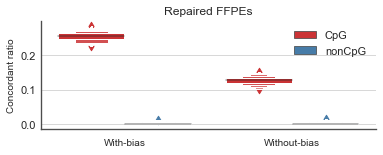

In [14]:
sns.set(rc={"figure.figsize":(6, 2)})
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                     'ytick.major.size': 2,
                                                     'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})
sns.boxenplot(x = 'bias_info', y = 'ratio', data = ratio_sim_repaired_df, hue = "site_info", palette= "Set1")
plt.legend (title = "", ncol = 1, frameon = False)
plt.title("Repaired FFPEs")
sns.despine()
plt.ylabel ("Concordant ratio", fontsize = 10)
plt.xlabel ("")

plt.xticks(fontsize = 10)
##plt.savefig("./Figures/Fig_R3a.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

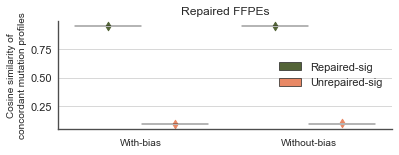

In [15]:
sns.set(rc={"figure.figsize":(6, 2)})
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                     'ytick.major.size': 2,
                                                     'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})
sns.boxenplot(x = 'bias_info', y = 'sim', data = ratio_sim_repaired_df, hue = "sig_info", palette= {"Repaired-sig":'darkolivegreen', "Unrepaired-sig": 'coral'})
plt.legend (title = "", loc = "center right", ncol = 1, frameon = False)
sns.despine()
plt.title ("Repaired FFPEs")
plt.ylabel ("Cosine similarity of\nconcordant mutation profiles", fontsize = 10)
plt.xlabel ("")
plt.xticks(fontsize = 10)
#plt.savefig("./Figures/Fig_R3b.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

# Visualise the derived signatures from biased and unbiased samples in the above simulation

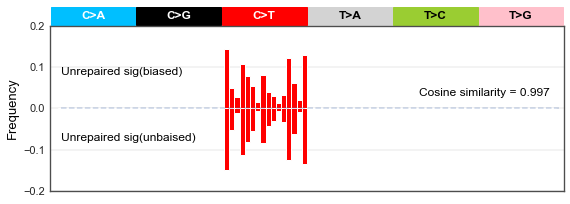

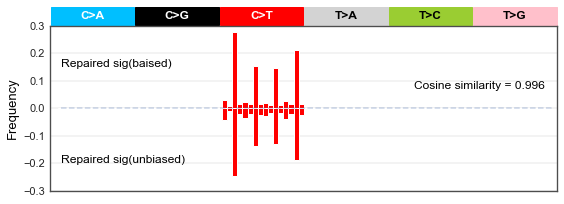

In [16]:
col_set = ['deepskyblue','black','red','lightgrey','yellowgreen','pink']
col_list = []
for i in range (len(col_set)):
     col_list += [col_set[i]] * 16
channel6 = ['C>A','C>G','C>T','T>A','T>C','T>G']

cs_repaired = np.round(cosine_similarity(repaired_unbias_sig.reshape(1,96), repaired_bias_sig.reshape(1,96))[0],3)
cs_unrepaired = np.round(cosine_similarity(unrepaired_unbias_sig.reshape(1,96), unrepaired_bias_sig.reshape(1,96))[0],3)
for sig1, sig2, sig1_name,sig2_name, cs in zip([unrepaired_bias_sig.copy(),repaired_bias_sig.copy()],
                                               [unrepaired_unbias_sig.copy(),repaired_unbias_sig.copy()],
                                               ["Unrepaired sig(biased)","Repaired sig(baised)"],
                                               [ "Unrepaired sig(unbaised)", "Repaired sig(unbiased)"], 
                                               [cs_unrepaired[0], cs_repaired[0]]):

    sns.set(rc={"figure.figsize":(8, 2.9)})
    sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                     'ytick.major.size': 2,
                                                     'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})

    plt.bar(np.arange(1,97), sig1, color = col_list, width = 1)
    
    plt.bar(np.arange(1,97), -sig2, color = col_list, width = 1)
        
    plt.hlines (0, 1, 97, linestyle='dashed', alpha = 0.3)
    
    for i in range (33,50):
        if sig1[i-1] >0.05  or sig2[i-1] > 0.05:
            if sig1[i-1]/sig2[i-1] > 2 or sig2[i-1]/sig1[i-1] > 2:
                plt.text( i, sig1[i-1] + 0.01, "*", ha = 'center',va='center', size = 12)

    plt.margins(x=0.01, y=0.01)
    plt.xticks ([])
    plt.ylabel("Frequency", color = "black", size = 13)
    
    text_col = ["w","w","w","black","black","black"]
    for i in range(6):
        
        left, width = 0 + 1/6 * i + 0.001, 1/6 - 0.002
        
        bottom, height = 1.003, 0.11
        right = left + width
        top = bottom + height
        ax = plt.gca()
        p = plt.Rectangle((left, bottom), width, height, fill=True, color = col_set[i])
        p.set_transform(ax.transAxes)
        p.set_clip_on(False)
        ax.add_patch(p)
        
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), channel6[i], weight = "bold", 
                color = text_col[i], size = 12,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
        
    plt.tight_layout()
    
    if sig1_name == "Unrepaired sig(biased)":
        plt.ylim (-0.2,0.2)
        plt.annotate (sig2_name,(1, -0.08), size = 12 , color = "black")
        plt.annotate (sig1_name,(1, 0.08), size = 12 , color = "black")
        plt.annotate (f"Cosine similarity = {cs}",(70, 0.03), 
                      size = 12, color = "black")
        plt.savefig("./Figures/FigR3c.pdf", bbox_inches = "tight", dpi = 300)
    else:
        plt.ylim (-0.3,0.3)
        plt.annotate (sig2_name,(1, -0.2), size = 12 , color = "black")
        plt.annotate (sig1_name,(1, 0.15), size = 12 , color = "black")
        plt.annotate (f"Cosine similarity = {cs}",(70, 0.07), 
                      size = 12, color = "black")
        plt.savefig("./Figures/FigR3d.pdf", bbox_inches = "tight", dpi = 300)
    
    plt.show()